<a href="https://colab.research.google.com/github/milanazhang/data-course-sample/blob/main/content-based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content=based Code

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2022-01-02 16:01:26--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv.2’

All_Beauty.csv.2    100%[===================>]  14.78M  8.23MB/s    in 1.8s    

2022-01-02 16:01:28 (8.23 MB/s) - ‘All_Beauty.csv.2’ saved [15499476/15499476]

--2022-01-02 16:01:28--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz.2’

meta_All_Beauty.jso 100%[===================>]   9.85M  6.59MB/s    in 1.5s   

In [3]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [4]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [5]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 資料整理

In [6]:
import numpy as np
import re

In [7]:
#將資料裡空list換成np.NaN，統計每個欄位有多少空值
metadata.head()
metadata_fillna = metadata.mask(metadata.applymap(str).eq('[]'))
metadata_fillna = metadata_fillna.replace('',np.NaN)
metadata_fillna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32892 entries, 0 to 32891
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   category         0 non-null      float64
 1   tech1            10 non-null     object 
 2   description      15119 non-null  object 
 3   fit              0 non-null      float64
 4   title            32891 non-null  object 
 5   also_buy         6597 non-null   object 
 6   tech2            0 non-null      float64
 7   brand            17219 non-null  object 
 8   feature          269 non-null    object 
 9   rank             32515 non-null  object 
 10  also_view        8132 non-null   object 
 11  details          32892 non-null  object 
 12  main_cat         32892 non-null  object 
 13  similar_item     1304 non-null   object 
 14  date             19 non-null     object 
 15  price            11459 non-null  object 
 16  asin             32892 non-null  object 
 17  imageURL    

In [8]:
#移除資料裡有重複的部分，保留不重複的資料的index
metadata_fillna=metadata_fillna.astype('str')
metadata_fillna.drop_duplicates(inplace=True)
remain_index = metadata_fillna.index

In [9]:
#挑選需要欄位與資料與整理欄位內的特殊符號
metadata_df = metadata.iloc[list(remain_index)][["asin","also_buy","also_view","rank","similar_item","price","brand","description","title","details"]]
metadata_df = metadata_df.replace(r'^\s*$', np.NaN, regex = True)

In [10]:
#將rank分成排名與商品子集
metadata_df['rank'] = metadata_df['rank'].str.replace(',', '')
metadata_df['sub_cat'] = metadata_df['rank'].str.extract(r'(\d+) in (.*) \($')[1].str.replace('&amp;','&')
metadata_df['rank_num'] = pd.to_numeric(metadata_df['rank'].str.extract(r'(\d+) in (.*) \($')[0])
metadata_df = metadata_df.drop("rank",axis=1)

In [11]:
#將similar_item從字串擷取出來
metadata_df["similar_item"] = metadata_df["similar_item"].apply(lambda x : [i[1] for i in re.findall(r'(/dp/)(.*)(/ref=)',x)] if isinstance(x,str) else np.NaN)

In [12]:
#將price的數字擷取出來
metadata_df["price"] = metadata_df["price"].str.replace(',','').str.extract(r'^(\$)(.+)$')[1]
metadata_df["price"] = metadata_df["price"].fillna("-").apply(lambda x: x if '-' not in x else np.NaN)
metadata_df["price"] = metadata_df["price"].astype("float")

In [13]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

## Text Normalization

In [14]:
!pip install nltk

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import csr_matrix, hstack

In [16]:
# define functions to preprocessing
from string import punctuation
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop_words = stopwords.words('english')


def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

def remove_stopwords(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop_words])
    return x

def remove_number(x):
    x = re.sub(r"\d+",'',x)
    x = re.sub(r"  ",' ',x)
    return x

def to_lower(x):
    return x.lower()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# preprocessing
porter = PorterStemmer()
metadata_df["title"] = metadata_df["title"].fillna("").apply(porter.stem)
metadata_df["title"] = metadata_df["title"].apply(remove_punctuation).apply(remove_stopwords).apply(remove_number).apply(to_lower)
metadata_df["description"] = metadata_df["description"].apply(lambda x : " ".join(x)).fillna("").apply(porter.stem)
metadata_df["description"] = metadata_df["description"].apply(remove_punctuation).apply(remove_stopwords).apply(remove_number).apply(to_lower)
metadata_df['title_description'] = metadata_df[['title', 'description']].agg(' '.join, axis=1)

# EDA

## metadata

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Beauty & Personal Care 32015
nan 402
Grocery & Gourmet Food 37
Health & Household 21
Sports & Outdoors 3
Toys & Games 3
Baby 2
Clothing Shoes & Jewelry 2
Home & Kitchen 1
Automotive 1
Tools & Home Improvement 1


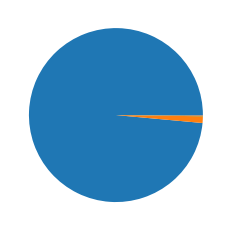

In [81]:
#統計商品子集有多少種及各種所佔的數量(不用main_cat的原因為，所有資料的main_cat都是一樣的)
rank_dict = {}
for i in metadata_df['sub_cat'].to_list():
  if rank_dict.get(i) != None:
    rank_dict[i] += 1
  else:
    rank_dict[i] = 1
for key in rank_dict.keys():
  print(key,rank_dict[key])

plt.pie(rank_dict.values())
plt.show()

('ASIN', 32381)
('Shipping Weight', 19779)
('UPC', 15377)
('Item model number', 5483)
('Product Dimensions', 5218)
('Item Weight', 3476)
('Domestic Shipping', 1328)
('International Shipping', 1328)
('Discontinued by manufacturer', 257)
('Batteries', 87)
('Shipping Advisory', 7)


<BarContainer object of 11 artists>

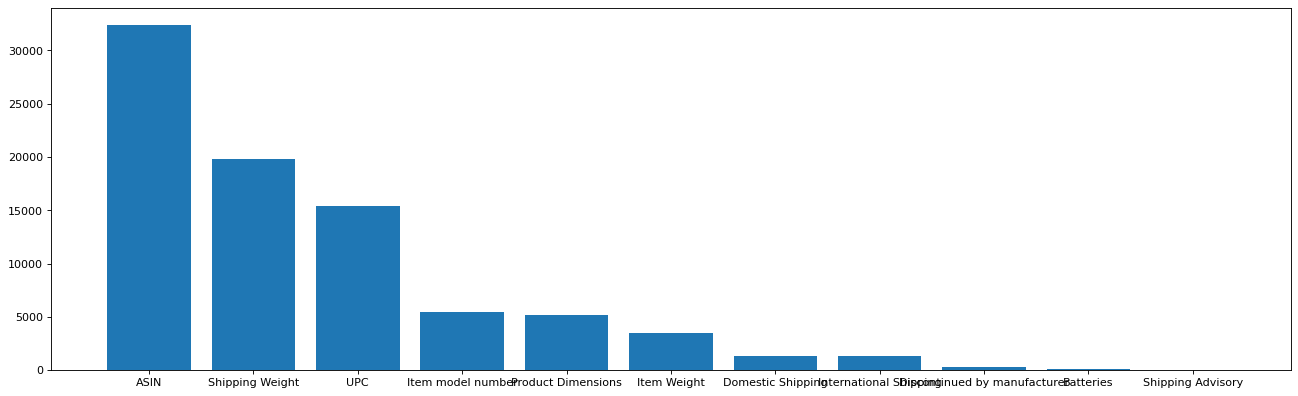

In [82]:
#統計商品的detail裡面有多少種資訊及各種所佔的數量
detail_key = {}
for index,row in metadata_df[["details"]].iterrows():
  for k in row['details'].keys():
    r_k = re.sub(r'\n    ','',k).strip(" ").strip(":")
    if detail_key.get(r_k) != None:
      detail_key[r_k] += 1
    else:
      detail_key[r_k] = 1
for k in sorted(detail_key.items(),key=lambda x : x[1],reverse=True):
  print(k)

plt.figure(figsize=(20, 6), dpi=80)
sort_detail = dict(sorted(detail_key.items(), key=lambda item: item[1],reverse=True))
plt.bar(x=sort_detail.keys(),height=sort_detail.values())

In [ ]:
#ratings中有不存在在metadata的商品，共100個，推薦時可能要加以排除
rating_asin_set = set(ratings["asin"].to_list())
all_asin_set = set(metadata_df["asin"].to_list())
print(len(rating_asin_set - all_asin_set))

100


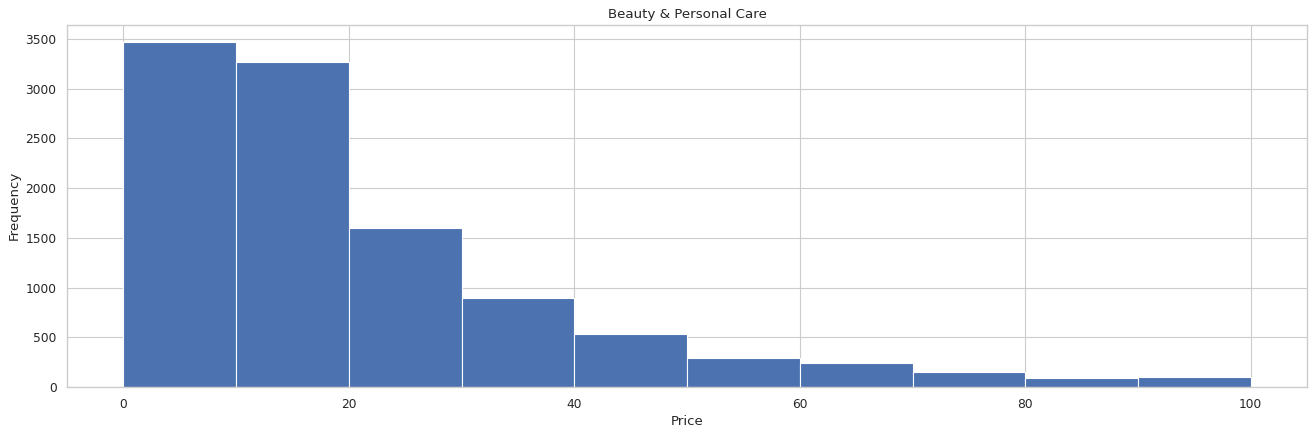

In [153]:
#商品的價格分布呈現right-skewed
fig = px.box(metadata_df[metadata_df["sub_cat"] == "Beauty & Personal Care"], y = "sub_cat", x="price", orientation='h')
fig.show()
data = metadata_df[(metadata_df["sub_cat"] == "Beauty & Personal Care") & (metadata_df["price"] <= 100)]['price'].to_list()

plt.figure(figsize=(20, 6), dpi=80)
n, bins, patches=plt.hist(data)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Beauty & Personal Care")
plt.show()

In [105]:
#大部分brand都只有1-3種商品
brand_key = {}
for k in metadata_df[metadata_df["brand"].notna()]["brand"].to_list():
  if brand_key.get(k) != None:
    brand_key[k] += 1
  else:
    brand_key[k] = 1
tmp_df = pd.DataFrame({"product_num":list(brand_key.values())})
fig = px.box(tmp_df, x="product_num", orientation='h')
fig.show()

## ratings

In [109]:
ratings["year"] = ratings["DATE"].astype(str).str.extract("(\d\d\d\d)-(\d\d)-(\d\d)")[0]
ratings["month"] = ratings["DATE"].astype(str).str.extract("(\d\d\d\d)-(\d\d)-(\d\d)")[1]
ratings["day"] = ratings["DATE"].astype(str).str.extract("(\d\d\d\d)-(\d\d)-(\d\d)")[2]

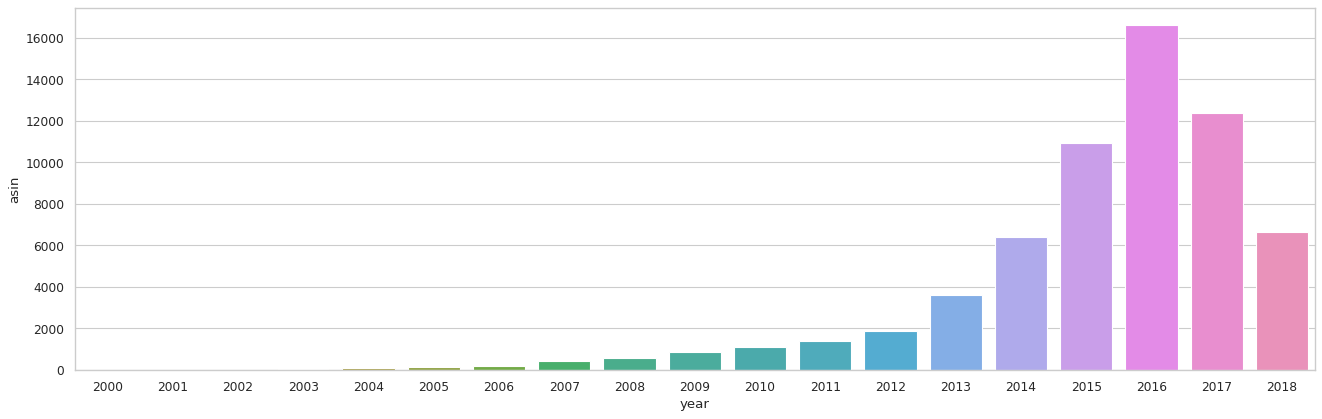

In [110]:
tmp_df = ratings.groupby("year").nunique("asin").reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 6), dpi=80)
ax = sns.barplot(x="year", y="asin", data=tmp_df)

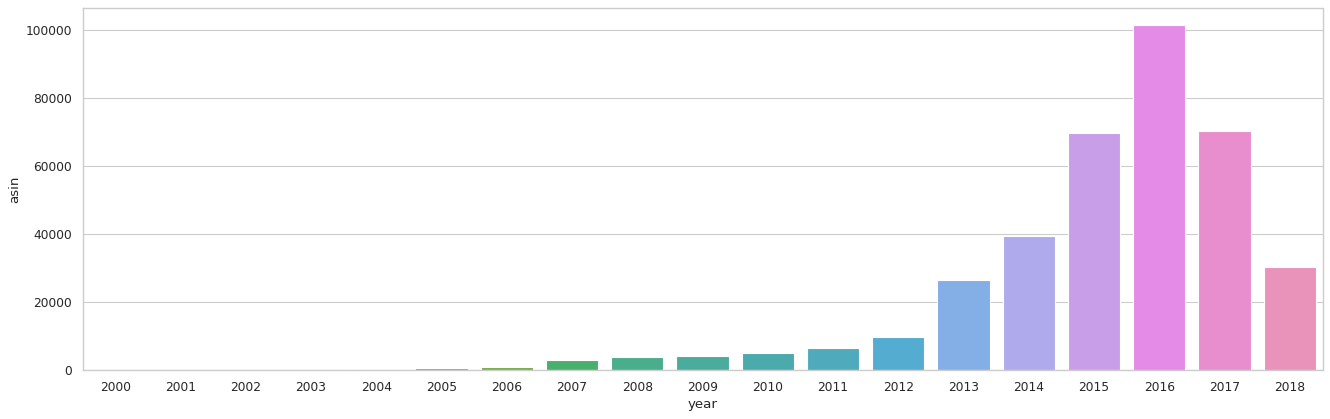

In [112]:
tmp_df = ratings.groupby("year")["asin"].count().reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 6), dpi=80)
ax = sns.barplot(x="year", y="asin", data=tmp_df)

In [147]:
ratings_sort = ratings.groupby(["year","asin"]).size().reset_index(name='counts').sort_values(by=["year","counts"],ascending=False).groupby("year").head(10)
ratings_sort = ratings_sort.groupby('year',as_index=False).agg(sum=("counts",sum)).merge(ratings_sort,on="year",how='right')
ratings_sort["percent"] = ratings_sort["counts"]*100/ratings_sort["sum"]

In [149]:
import plotly.express as px
fig = px.bar(ratings_sort,x="year",y="percent",color="asin")
fig.show()

In [151]:
metadata_df[metadata_df["asin"].isin(["B000FOI48G","B000GLRREU"])]

,asin,also_buy,also_view,similar_item,price,brand,description,title,details,sub_cat,rank_num,title_description
1254,B000FOI48G,"[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...","[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...",NaN,NaN,Waterpik,premium dental water jet dramatically improved...,waterpik ultra water floss,{' Product Dimensions: ': '7 x 9 x 6 ...,Beauty & Personal Care,19437.0,waterpik ultra water floss premium dental wate...
1374,B000GLRREU,"[B003FSTE4W, B001NIZ5U8, B00CU9VF2Q, B0062N798...","[B0755JQ4RF, B010NNIZQE, B07H5KV2J1, B01I9TIJQ...",NaN,NaN,Waterpik,premium dental water jet dramatically improved...,waterpik ultra water floss,{' Product Dimensions: ': '7 x 9 x 6 ...,Beauty & Personal Care,20356.0,waterpik ultra water floss premium dental wate...


# 資料切分

In [18]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

# For Rule-Based

## 創造特徵

---



In [19]:
#計算商品總聲量與正面聲量(正面定義為評分4以上)
volume_sum = {ratings["asin"]:ratings["reviewerID"] for ratings in ratings_trainings.groupby("asin").count().reset_index()[["asin","reviewerID"]].to_dict('records')}
good_ratings = ratings_trainings[ratings_trainings["overall"] >= 4]
volume_good = {ratings["asin"]:ratings["reviewerID"] for ratings in good_ratings.groupby("asin").count().reset_index()[["asin","reviewerID"]].to_dict('records')}

In [20]:
#計算商品回購間隔時間
from datetime import timedelta
date_sort = ratings_trainings.sort_values(['DATE'],ascending=True).groupby(["asin", "reviewerID"]).head(11)
date_sort['dur'] = date_sort.groupby(['asin', 'reviewerID'])["DATE"].apply(lambda x: x.diff(1))
repurchase = date_sort[date_sort["dur"].notna()][date_sort[date_sort["dur"].notna()]["dur"] != "0 days"]
repurchase["dur"] = repurchase["dur"].astype("str").str.extract(r'(\d+) (.*$)')[0].astype(int)
purchase_dur = {d["asin"]:d["dur"] for d in repurchase.groupby("asin").agg({"dur":pd.Series.median}).reset_index()[["asin","dur"]].to_dict('records')}

In [21]:
#計算每個商品的回購人數與總購買人數
repurchase_num = {d["asin"]:len(set(d["reviewerID"])) for d in repurchase[['reviewerID', 'asin']].groupby('asin').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')}
purchase_sum = {d["asin"]:len(set(d["reviewerID"])) for d in ratings_trainings[['reviewerID', 'asin']].groupby('asin').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')}

In [22]:
#將上述產生的商品特徵整併進metadata裡
metadata_df["volume_sum"] = [volume_sum[v] if v in volume_sum.keys() else 0 for v in metadata_df["asin"].to_list()]
metadata_df["volume_good"] = [volume_good[v] if v in volume_good.keys() else 0 for v in metadata_df["asin"].to_list()]
metadata_df["purchase_dur"] = [purchase_dur[v] if v in purchase_dur.keys() else 0 for v in metadata_df["asin"].to_list()]
metadata_df["repurchase_num"] = [repurchase_num[v] if v in repurchase_num.keys() else 0 for v in metadata_df["asin"].to_list()]
metadata_df["purchase_sum"] = [purchase_sum[v] if v in purchase_sum.keys() else 0 for v in metadata_df["asin"].to_list()]
metadata_df["good_review_rate"] = [g/s if s>0 else 0 for g,s in list(zip(metadata_df["volume_good"].to_list(),metadata_df["volume_sum"].to_list()))]
metadata_df["repurchase_rate"] = [n/s if s>0 else 0 for n,s in list(zip(metadata_df["repurchase_num"].to_list(),metadata_df["purchase_sum"].to_list()))]

In [23]:
#將商品依據排序規則(正面聲量比例->總聲量->銷售排名)排序，將每個商品做出推薦排名
sorted_meta = metadata_df[["asin","good_review_rate","volume_sum","rank_num"]].sort_values(by=["good_review_rate","volume_sum","rank_num"], ascending=[False,False,True])
sorted_meta = sorted_meta.reset_index().drop("index",axis=1)
product_weight = {}
for i in range(0,len(sorted_meta)):
  if product_weight.get(sorted_meta.iloc[i]["asin"]) == None:
    product_weight[sorted_meta.iloc[i]["asin"]] = i

## 製作推薦商品列表

In [24]:
#將also_buy與also_view欄位經排序過後的結果存入also_buy_sort與also_view_sort欄位
metadata_df["also_buy_dict"] = metadata_df["also_buy"].apply(lambda x: {k:product_weight[k] if len(x) != 0 and product_weight.get(k)!=None else 40000 for k in x})
metadata_df["also_view_dict"] = metadata_df["also_view"].apply(lambda x: {k:product_weight[k] if len(x) != 0 and product_weight.get(k)!=None else 40000 for k in x})
metadata_df["also_buy_sort"] = metadata_df["also_buy_dict"].apply(lambda x : [k for k, v in sorted(x.items(), key=lambda item: item[1]) if v!=40000])
metadata_df["also_view_sort"] = metadata_df["also_view_dict"].apply(lambda x : [k for k, v in sorted(x.items(), key=lambda item: item[1]) if v!=40000])
metadata_df.drop(["also_buy","also_view","also_buy_dict","also_view_dict"],axis=1,inplace = True)

In [25]:
#將similar_item經排序後存入similar_item_sort的欄位
metadata_df["similar_item_weight"] = metadata_df["similar_item"].apply(lambda x : {i:product_weight[i] for i in x if product_weight.get(i)!=None} if isinstance(x,list) else {})
metadata_df["similar_item_sort"] = metadata_df["similar_item_weight"].apply(lambda x : [k for k, v in sorted(x.items(), key=lambda item: item[1]) if v!=40000])

In [26]:
#將同品牌的商品做成商品串
import warnings
warnings.filterwarnings("ignore")
metadata_df['brand'].fillna("notfound",inplace=True)
brand_dict = {d["brand"]:d["asin"] for d in metadata_df.groupby("brand").agg(list).reset_index()[['brand','asin']].to_dict("record")}

In [27]:
#將同品牌的商品排序存入same_brand_item_sort欄位
brand_weight_dict = {}
for i in brand_dict.keys():
  if brand_dict[i]!="notfound":
    tmp_dict = {}
    for k in brand_dict[i]:
      if product_weight.get(k) != None:
        tmp_dict[k] = product_weight[k]
    brand_weight_dict[i] = tmp_dict
brand_weight_sorted_dict = {k:[vk for vk,vv in sorted(v.items(),key=lambda item:item[1])] for k,v in brand_weight_dict.items()}

same_brand_item_list = []
for i in metadata_df["brand"].to_list():
  if brand_dict[i]!="notfound":
    same_brand_item_list.append(brand_weight_sorted_dict[i])
  else:
    same_brand_item_list.append({})

metadata_df["same_brand_item_sort"] = same_brand_item_list

In [28]:
#drop掉用不到的欄位
metadata_df.drop(["similar_item","similar_item_weight","brand","volume_good","repurchase_num","purchase_sum"],axis=1,inplace=True)
metadata_df.head()

,asin,price,description,title,details,sub_cat,rank_num,title_description,volume_sum,purchase_dur,good_review_rate,repurchase_rate,also_buy_sort,also_view_sort,similar_item_sort,same_brand_item_sort
0,6546546450,NaN,loud n clear personal sound amplifier allows t...,loud n cleartrade personal sound amplifi,{'ASIN: ': '6546546450'},Beauty & Personal Care,2938573.0,loud n cleartrade personal sound amplifi loud ...,2,0.0,0.500000,0.0,[],[],[],[6546546450]
1,7178680776,44.99,no lift luminate triple action serum ml boot,no lift amp luminate triple action serum ml boot,"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",Beauty & Personal Care,872854.0,no lift amp luminate triple action serum ml bo...,1,0.0,0.000000,0.0,[],[],[],"[B01BRJ8TF0, B01AD16KAO, B016QX70M0, B00KIYTQ8..."
2,7250468162,28.76,no stay perfect foundation stays perfect longe...,no stay perfect foundation cool vanilla no,"{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",Beauty & Personal Care,956696.0,no stay perfect foundation cool vanilla no no ...,1,0.0,1.000000,0.0,[],[],[],"[B01FN9KPGG, B01698HYD2, 7250468162, B013L800JI]"
3,7367905066,NaN,,wella koleston perfect hair colour medium inte...,"{' Item Weight: ': '1.76 ounces', 'Sh...",Beauty & Personal Care,1870258.0,wella koleston perfect hair colour medium inte...,1,0.0,1.000000,0.0,[],[],[],"[B01BRJ8TF0, B01AD16KAO, B016QX70M0, B00KIYTQ8..."
4,7414204790,12.15,lacto calamine skin balance daily nourishing l...,lacto calamine skin balance oil control ml pack,"{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",Beauty & Personal Care,67701.0,lacto calamine skin balance oil control ml pac...,15,0.0,0.866667,0.0,[],[],[],[7414204790]


# 產生推薦

## rule-based recommendation

In [29]:
#將總聲量與正面聲量排序的計算縮限在1個月內
def rule_base_recommender(training_data, users=[], k=10, period_time='2018-08-01'):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    volume_sum = {ratings["asin"]:ratings["reviewerID"] for ratings in ratings_trainings[ratings_trainings["DATE"]>period_time].groupby("asin").count().reset_index()[["asin","reviewerID"]].to_dict('records')}
    good_ratings = ratings_trainings[(ratings_trainings["overall"] >= 4) & (ratings_trainings["DATE"]>'2017-08-31')]
    volume_good = {ratings["asin"]:ratings["reviewerID"] for ratings in good_ratings.groupby("asin").count().reset_index()[["asin","reviewerID"]].to_dict('records')}
    metadata_df["volume_sum"] = [volume_sum[v] if v in volume_sum.keys() else 0 for v in metadata_df["asin"].to_list()]
    metadata_df["volume_good"] = [volume_good[v] if v in volume_good.keys() else 0 for v in metadata_df["asin"].to_list()]
    metadata_df["good_review_rate"] = [g/s if s>0 else 0 for g,s in list(zip(metadata_df["volume_good"].to_list(),metadata_df["volume_sum"].to_list()))]

    metadata_dict = metadata_df[["asin","purchase_dur","repurchase_rate","rank_num", "volume_sum","good_review_rate","also_buy_sort","also_view_sort","similar_item_sort","same_brand_item_sort","sub_cat","rank_num"]].to_dict("record")
    metadata_dict = {d["asin"]:[d["purchase_dur"],d["repurchase_rate"],d["rank_num"], d["volume_sum"],d["good_review_rate"],d["also_buy_sort"],d["also_view_sort"],d["similar_item_sort"],d["same_brand_item_sort"],d["sub_cat"],d["rank_num"]] for d in metadata_dict}
    recommendations = {}
    for u in users:
      recommendations[u] = set()
      products_dict = {d["asin"]:d["overall"] for d in training_data[(training_data['reviewerID'] == u) & (training_data['overall'] >= 4)][["asin","overall"]].to_dict("record")}
      products_sort = {k:v for k,v in sorted(products_dict.items(),key=lambda item:item[1])}
      ##找出買過會再次回購的商品
      for key in products_sort.keys():
        last_buy_time = training_data[(training_data["reviewerID"] == u) & (training_data["asin"] == key)]["DATE"].max() 
        if metadata_dict[key][1]>0 and metadata_dict[key][0]>(training_data["DATE"].max()-last_buy_time).days:
          if len(recommendations[u]) == 10:
            break
          recommendations[u].add(key)
      ##還不夠K個，找also buy中排序過後的商品
      outside_break = False
      for key in products_sort.keys():
        for item in metadata_dict[key][5]:
          if len(recommendations[u]) == 10:
            outside_break = True
            break
          recommendations[u].add(item)
        if outside_break == True:
          break
      ##還不夠K個，找also view中排序過後的商品
      outside_break = False
      for key in products_sort.keys():
        for item in metadata_dict[key][6]:
          if len(recommendations[u]) == 10:
            outside_break = True
            break
          recommendations[u].add(item)
        if outside_break == True:
          break
      ##還不夠K個，找similar item中排序過後的商品
      outside_break = False
      for key in products_sort.keys():
        for item in metadata_dict[key][7]:
          if len(recommendations[u]) == 10:
            outside_break = True
            break
          recommendations[u].add(item)
        if outside_break == True:
          break
      ##還不夠K個，找same brand中排序過後的商品
      outside_break = False
      for key in products_sort.keys():
        for item in metadata_dict[key][8]:
          if len(recommendations[u]) == 10:
            outside_break = True
            break
          recommendations[u].add(item)
        if outside_break == True:
          break
      ##還不夠K個，找所有同種商品中總聲量排序後的商品
      metadata_sell_sort = metadata_df.sort_values(['volume_sum'],ascending=False).groupby("sub_cat").head(10)
      outside_break = False
      for key in products_sort.keys():
        sub_cat = metadata_dict[key][9]
        for item in metadata_sell_sort[metadata_sell_sort["sub_cat"] == sub_cat]["asin"].to_list():
          if len(recommendations[u]) == 10:
            outside_break = True
            break
          recommendations[u].add(item)
        if outside_break == True:
          break
      ##還不構K個，代表此消費者在training data沒出現過或是同種商品沒到K個，故直接推薦子類別為美妝且最總聲量最高的產品
      for key in metadata_sell_sort[metadata_sell_sort["sub_cat"] == "Beauty & Personal Care"]["asin"].to_list():
        if len(recommendations[u]) == 10:
          break
        recommendations[u].add(key)
    return recommendations


## content-based recommendation

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 計算商品用標題與description所表示的 tfidf 矩陣
df = metadata_df.drop_duplicates('title_description')
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df['title_description'])

### TFIDF similarity

In [118]:
# 計算商品間的相似程度
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)
mapping = pd.Series(df.index,index = df['title_description'])

# 每個商品回傳 k 個最相近的商品
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    if len(res) == 0:
      return {}
    else:
      return set(res)

In [121]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    user_to_rule_base = set()
    for user in users:

        # content based
        asin_list = ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist()
        recom_list = recommend_items(metadata_df[metadata_df['asin'].isin(asin_list)]['title_description'].tolist(), k)
        if len(recom_list) != 0:
            # 有在training data裡的消費者
            sorted_recom_list = []
            #將similar item的欄位商品加入
            for i in metadata_df[(metadata_df['asin'].isin(asin_list)) & (metadata_df["good_review_rate"]>0)]["similar_item_sort"].to_list():
              if len(i) != 0:
                sorted_recom_list.append(i)
            if len(sorted_recom_list) < 10:
              for item in metadata_df[metadata_df['asin'].isin(recom_list)]["asin"].to_list():
                sorted_recom_list.append(item)
                if len(sorted_recom_list) == 10:
                  break
            recommendations[user] = sorted_recom_list
        else:
            # 沒在training data裡的消費者使用rule based
            user_to_rule_base.add(user)
    rule_base_recommendations = rule_base_recommender(ratings_trainings, user_to_rule_base)
    recommendations.update(rule_base_recommendations)
    return recommendations

ratings_by_user1 = recommender(ratings_trainings, users)
#ratings_by_user1

In [123]:
del similarity_matrix

### TFIDF clustering

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
sil = []
K = [50,60,70,80,90]

for k in K:
  kmeanModel = KMeans(n_clusters=k)
  kmeanModel.fit(tfidf_matrix)
  labels = kmeanModel.labels_
  sil.append(silhouette_score(tfidf_matrix, labels, metric = 'euclidean'))

KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: ignored

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


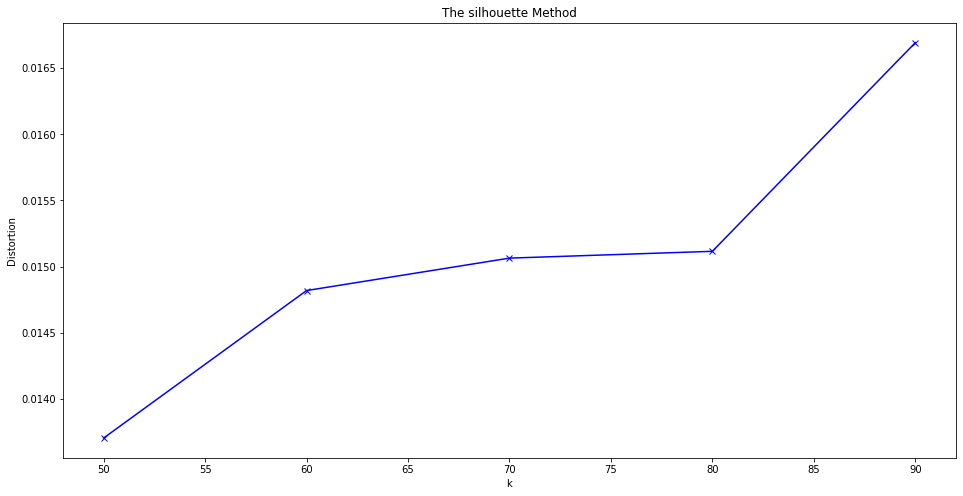

In [129]:
#find the appropriate n_cluster
plt.figure(figsize=(16,8))
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The silhouette Method')
plt.show()

In [76]:
distortions = []
K = [50,60,70,80]
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(tfidf_matrix)
    distortions.append(kmeanModel.inertia_)

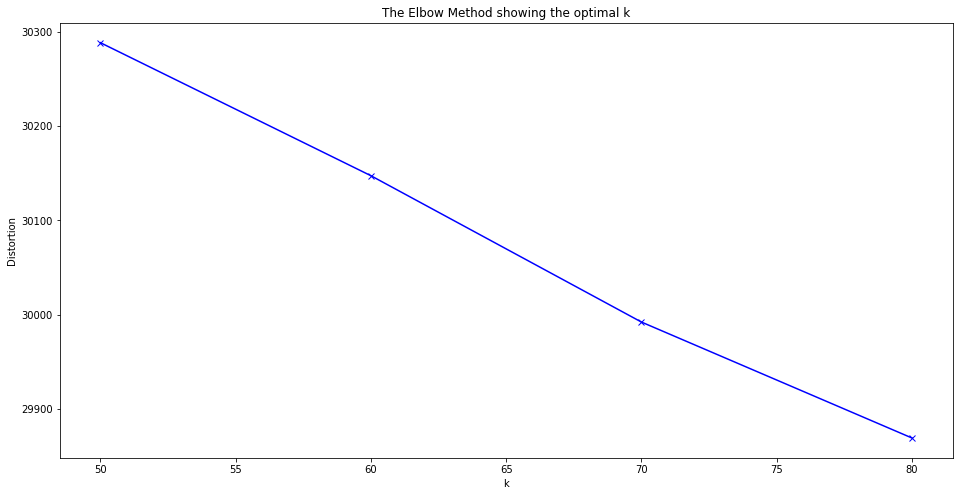

In [77]:
#find the appropriate n_cluster
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

In [31]:
# initialize kmeans with 90 centroids
kmeans = KMeans(n_clusters=90, random_state=42)
kmeans.fit(tfidf_matrix)
clusters = kmeans.labels_

In [32]:
df["cluster"] = clusters

In [33]:
df.groupby("cluster").count()["title"].sort_values(ascending=False)/len(df)

cluster
74    0.217470
53    0.033116
15    0.033053
13    0.028773
55    0.028430
        ...   
6     0.001906
25    0.001874
77    0.001874
42    0.001593
45    0.001468
Name: title, Length: 90, dtype: float64

In [42]:
word_dict = {}
for i in df[df["cluster"]==74]["title_description"].to_list():
  for w in i.split(" "):
    if w == ' ' or w == '' or w == 'tr' or w == 'td' or w == 'bordertd' or w == 'use' or w == 'aligncenterimg':
      continue
    elif word_dict.get(w) != None:
      word_dict[w] += 1
    else:
      word_dict[w] = 1

In [43]:
new_word_dict = {}
for k in word_dict.keys():
  if word_dict[k] > 100:
    new_word_dict[k] = word_dict[k]

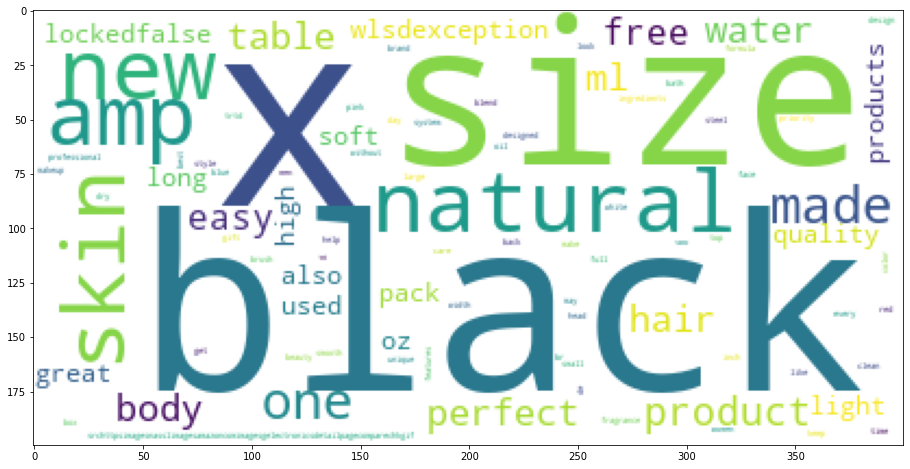

In [44]:
#cluster 74 words
from wordcloud import WordCloud
cloud = WordCloud(background_color='white').generate_from_frequencies(new_word_dict)
plt.figure(figsize=(16,8))
plt.imshow(cloud)

In [60]:
# 每個商品回傳 k 個屬同cluster的商品
def recommend_item(item_input, k=10):
    try:
        item_cluster = df[df["title_description" == item_input]]["cluster"].to_list()[0]
        recom_items = df[df["cluster"] == item_cluster]["asin"].to_list()[:k]
        return (recom_items)
    except:
        return []

# 利用使用者購買過的商品產生推薦
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    if len(res) == 0:
      return {}
    else:
      return set(res)

In [61]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    content-based
    '''
    ratings_trainings = training_data
    user_to_rule_base = set()
    for user in users:

        # content based
        asin_list = ratings_trainings[ratings_trainings['reviewerID'] == user]['asin'].tolist()
        recom_list = recommend_items(metadata_df[metadata_df['asin'].isin(asin_list)]['title_description'].tolist(), k)
        if len(recom_list) != 0:
            # 有在training data裡的消費者
            sorted_recom_list = []
            #將similar item欄位的商品加入
            for i in metadata_df[(metadata_df['asin'].isin(asin_list)) & (metadata_df["good_review_rate"]>0)]["similar_item_sort"].to_list():
              if len(i) != 0:
                sorted_recom_list.append(i)
            if len(sorted_recom_list) < 10:
              for item in metadata_df[metadata_df['asin'].isin(recom_list)]["asin"].to_list():
                sorted_recom_list.append(item)
                if len(sorted_recom_list) == 10:
                  break
            recommendations[user] = sorted_recom_list
        else:
            # 沒在training data裡的消費者使用rule based
            user_to_rule_base.add(user)
    rule_base_recommendations = rule_base_recommender(ratings_trainings, user_to_rule_base)
    recommendations.update(rule_base_recommendations)
    return recommendations

ratings_by_user2 = recommender(ratings_trainings, users)
#ratings_by_user2

## 結果評估

In [124]:
#使用cosine similarity計算
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user1)

0.15084745762711865

In [62]:
#使用K-means分群
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user2)

0.15593220338983052

### testing中的消費者只有38位有在過去購買過商品

In [55]:
testing_user = set(ratings_testings["reviewerID"].to_list())
training_user = set(ratings_trainings["reviewerID"].to_list())

In [56]:
len(testing_user - training_user)

546

In [57]:
len(training_user & testing_user)

38